In [30]:
# ==============================================================================
# 03_Global_Interpretability.ipynb
# ==============================================================================
# GOAL: Demystify the Black Box using Global Surrogate Models & PDP.
# STRATEGY: 
# 1. Use XGBoost predictions as the "Ground Truth" for simpler models.
# 2. Train a Decision Tree (to get rules) and Linear Regression (to get coefficients).
# 3. Use Partial Dependence Plots (PDP) to show marginal effects.
# ==============================================================================


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost as xgb
import warnings
import shap

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

# Settings
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
pd.set_option('display.max_columns', None)

print("✅ Libraries Loaded.")

✅ Libraries Loaded.


In [31]:
xgb_model = joblib.load('../models/champion_model.joblib')
calibrator = joblib.load('../models/calibrator.joblib')
model = xgb_model  # Alias for compatibility with older code
feature_names = joblib.load('../models/model_features.joblib')
print(f"✅ Loaded Champion Model: {type(xgb_model).__name__}")
print(f"✅ Loaded calibrator")


X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
print(f"✅ Loaded Data. Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

✅ Loaded Champion Model: XGBClassifier
✅ Loaded calibrator
✅ Loaded Data. Train Shape: (957145, 41), Test Shape: (94893, 41)


In [32]:
import pandas as pd
import re

# 1. 强制清理当前数据框的列名 (防止有空格或特殊字符残留)
def sanitize_feature_names(df):
    new_cols = []
    for col in df.columns:
        # 替换所有非字母、数字和下划线的字符
        new_col = re.sub(r'[\s\[\]<]', '_', col).strip('_')
        new_cols.append(new_col)
    df.columns = new_cols
    return df

X_train = sanitize_feature_names(X_train)
X_test = sanitize_feature_names(X_test)
print("✅ Current feature names sanitized.")

# 2. 识别并创建缺失的特征 (One-Hot 编码常见问题)
# 这一步是为了处理在训练集和测试集中，某些 One-Hot 编码特征未出现的问题。
missing_in_train = set(feature_names) - set(X_train.columns)
missing_in_test = set(feature_names) - set(X_test.columns)

# 强制添加缺失的列，并用 0 填充（通常用于 One-Hot 编码特征）
for col in missing_in_train:
    X_train[col] = 0
for col in missing_in_test:
    X_test[col] = 0

if missing_in_train or missing_in_test:
    print(f"⚠️ Added {len(missing_in_train)} missing columns (set to 0) to X_train.")
    print(f"⚠️ Added {len(missing_in_test)} missing columns (set to 0) to X_test.")
    
# 3. 重新执行特征重排 (Reindexing)
# 现在列名已清理，并且所有需要的列都已存在（即使值是 0）

X_train = X_train[feature_names]
X_test = X_test[feature_names]
print("✅ Features successfully realigned to match model's expected order and names.")

# 4. 最终检查
if X_train.shape[1] == len(feature_names):
    print(f"✨ Final check successful. Feature count: {X_train.shape[1]}")
else:
    print("❌ Final feature count mismatch! Check dropped columns.")

✅ Current feature names sanitized.
⚠️ Added 1 missing columns (set to 0) to X_train.
⚠️ Added 1 missing columns (set to 0) to X_test.
✅ Features successfully realigned to match model's expected order and names.
✨ Final check successful. Feature count: 41


🤖 Generating XGBoost predictions (The 'Soft' Target)...


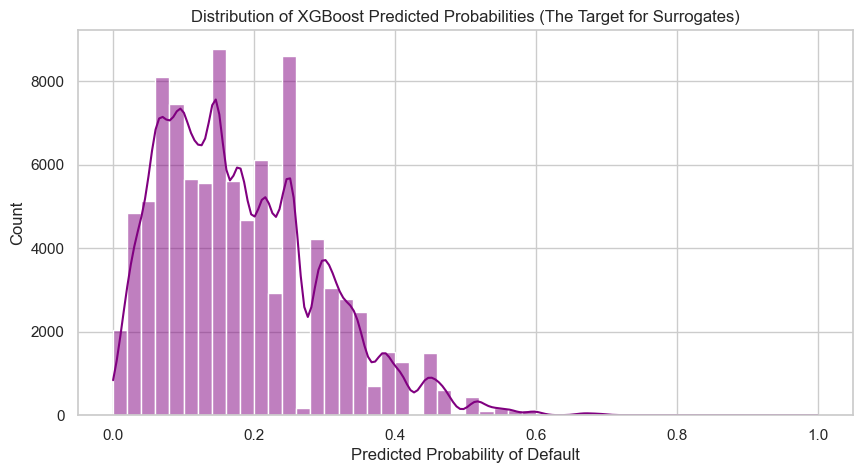

In [33]:
# ==========================================
# 2. Generate "Black Box" Predictions
# ==========================================
# The core idea: We treat the XGBoost PREDICTIONS as our new TARGET.
# We are modeling the model, not the ground truth.

print("🤖 Generating XGBoost predictions (The 'Soft' Target)...")

# Predict Probabilities (Continuous 0-1)
y_pred_xgb_train = calibrator.predict_proba(X_train)[:, 1]
y_pred_xgb_test = calibrator.predict_proba(X_test)[:, 1]

# Visualization: What does the XGBoost thinking look like?
plt.figure(figsize=(10, 5))
sns.histplot(y_pred_xgb_test, bins=50, kde=True, color='purple')
plt.title("Distribution of XGBoost Predicted Probabilities (The Target for Surrogates)")
plt.xlabel("Predicted Probability of Default")
plt.show()

📊 Generating XGBoost Built-in Feature Importance (Gain)...


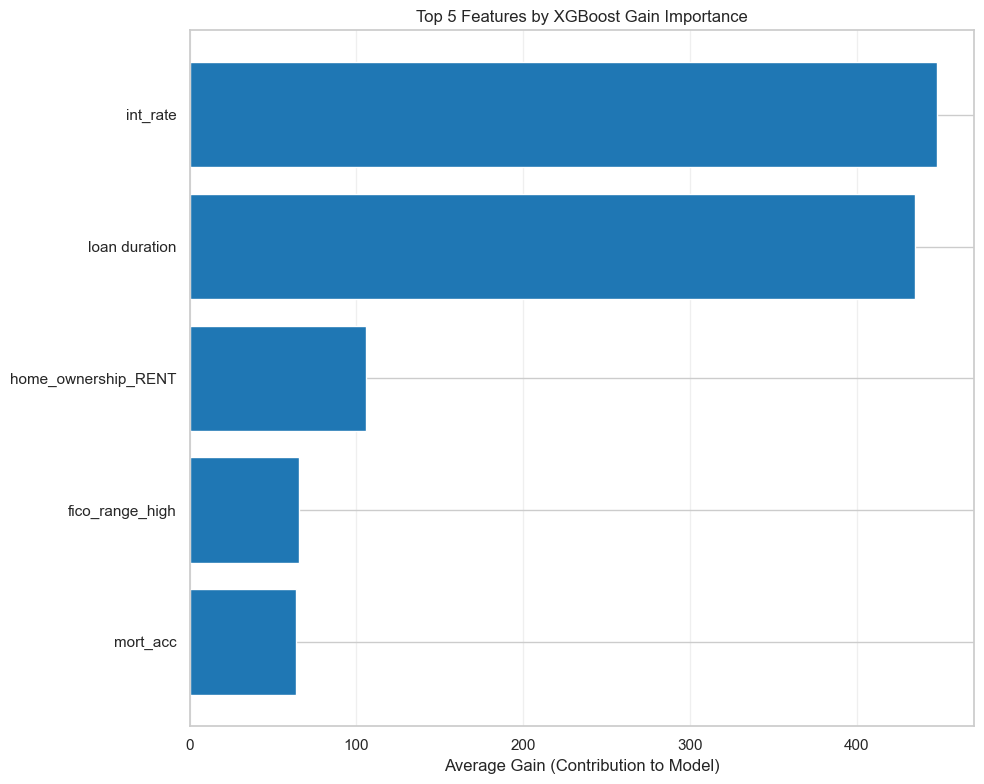


🧠 Generating SHAP Summary Plot (State-of-the-Art Interpretability)...
⏳ 计算 SHAP 值可能需要几分钟，请耐心等待...


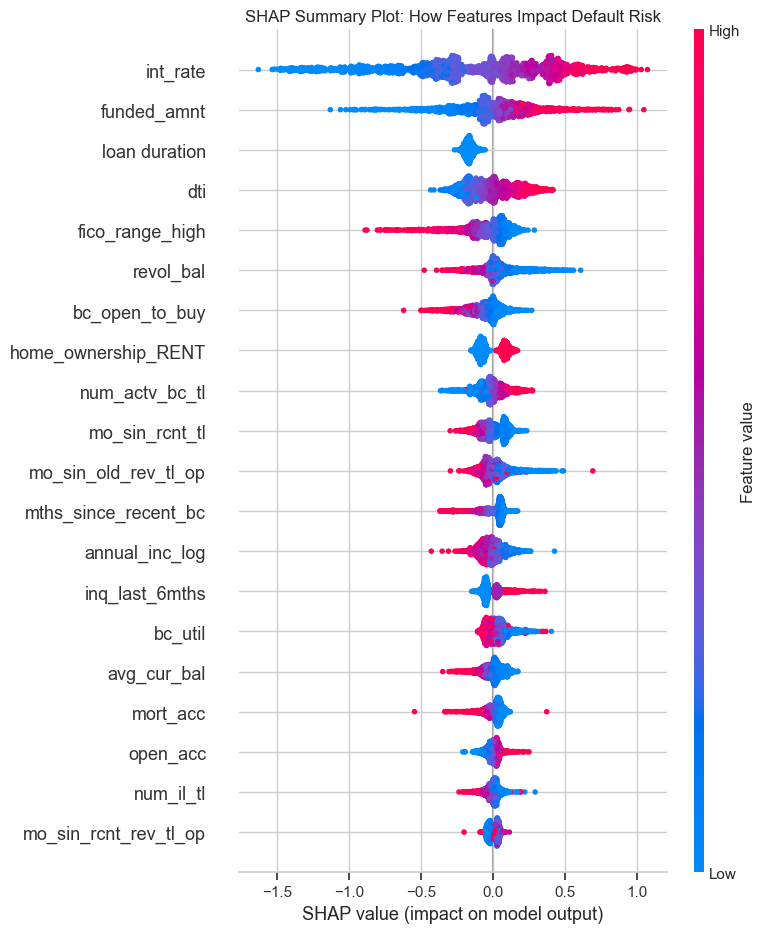

In [42]:
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
import pandas as pd
import numpy as np

# =========================================
# 方法 A：XGBoost 内置特征重要性 (基于 Gain)
# =========================================
print("📊 Generating XGBoost Built-in Feature Importance (Gain)...")

# 获取特征重要性字典
importance_dict = model.get_booster().get_score(importance_type='gain')

# 转换为 DataFrame 并排序
feat_imp = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Gain'])
feat_imp = feat_imp.sort_values(by='Gain', ascending=False).head(5) # 只看前5个

# 绘图
plt.figure(figsize=(10, 8))
plt.barh(feat_imp['Feature'][::-1], feat_imp['Gain'][::-1], color='#1f77b4')
plt.xlabel('Average Gain (Contribution to Model)')
plt.title('Top 5 Features by XGBoost Gain Importance')
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


# =========================================
# 方法 B：SHAP 值分析 (行业金标准 - 可解释性 AI)
# =========================================
print("\n🧠 Generating SHAP Summary Plot (State-of-the-Art Interpretability)...")
print("⏳ 计算 SHAP 值可能需要几分钟，请耐心等待...")

# 1. 创建解释器
# TreeExplainer 专用于树模型，速度快
explainer = shap.TreeExplainer(model)

# 2. 计算 SHAP 值
# 为了速度，我们从测试集中随机抽取 2000 个样本进行分析（足够代表整体）
X_test_sample = X_test.sample(n=2000, random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# 3. 绘制蜂群图 (Beeswarm Plot)
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_sample, plot_type="dot", show=False)
plt.title('SHAP Summary Plot: How Features Impact Default Risk')
plt.tight_layout()
plt.show()